***Import Libraries***

In [63]:
"""This program bilinearizes 3R planar dyanmics using koopman theory and autoencoder to map"""
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools

import torch

# bilinear Koopman
from core.koopman_core_linear import KoopDNN, KoopmanNet, KoopmanNetCtrl
from models.koop_model import model_matricies,lift

# forward map neural net
from core.neural_fwd_map import map_Net

# 2R dynamics and kinetics
from dynamics.robot_3R import dynamics_3R_data_gen, dynamics_3R, forward_kinematics_3R, forward_map_3R, Jacobian_3R

## import paths
from paths.paths import path_pars

***Simulation Parameters***

In [64]:
dt = 0.005 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 6 # no. of states
num_inputs = 3 # no. of inputs

In [65]:
T.shape

(1001,)

***Robot Parameters***

In [66]:
robot_pars = {}
# link lengths
robot_pars['a1'] = 0.33
robot_pars['a2'] = 0.33
robot_pars['a3'] = 0.33

#link masses
robot_pars['m1'] = 0.1
robot_pars['m2'] = 0.1
robot_pars['m3'] = 0.1

# link inertias
robot_pars['I1'] = 1
robot_pars['I2'] = 1
robot_pars['I3'] = 1

#position of CM
robot_pars['l1'] = 0.33/2
robot_pars['l2'] = 0.33/2
robot_pars['l3'] = 0.33/2

#dynamic friction coefficient
robot_pars['fd'] = 0.1


***Data Generation for 3R***

In [67]:
# Trajectories
X_end,X_full, U_full = dynamics_3R_data_gen(dt,num_traj, num_snaps,num_states,num_inputs,robot_pars)
print(X_end.shape, X_full.shape,U_full.shape)

(125, 1001, 2) (125, 1001, 6) (125, 1000, 3)


In [68]:
X_full.T.shape, X_full.dtype

((6, 1001, 125), dtype('float64'))

***Plotting the trajectories***

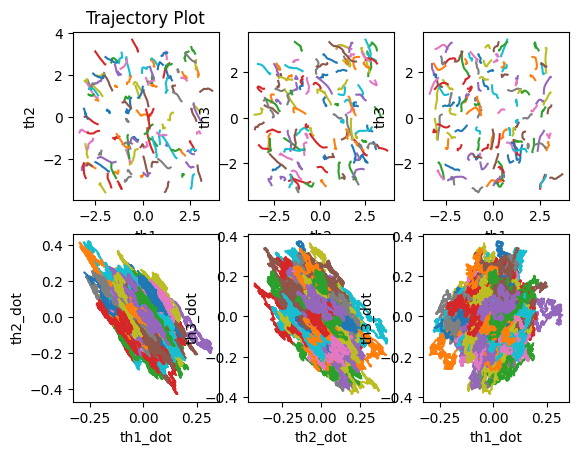

In [69]:
"""Training dataset visualization"""
#theta1 theta2 plot
plt.subplot(2,3,1)
plt.title("Trajectory Plot")
plt.xlabel("th1")
plt.ylabel("th2")
for i in range(num_traj):
  plt.plot(X_full[i,:,0],X_full[i,:,1])

#theta2 theta3 plot
plt.subplot(2,3,2)
plt.xlabel("th2")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,1],X_full[i,:,2])

#theta1 theta3 plot
plt.subplot(2,3,3)
plt.xlabel("th1")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,0],X_full[i,:,2])

#theta1_dot theta2_dot plot
plt.subplot(2,3,4)
plt.xlabel("th1_dot")
plt.ylabel("th2_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,4])

#theta2_dot theta3_dot plot
plt.subplot(2,3,5)
plt.xlabel("th2_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,4],X_full[i,:,5])

#theta1_dot theta3_dot plot
plt.subplot(2,3,6)
plt.xlabel("th1_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,5])



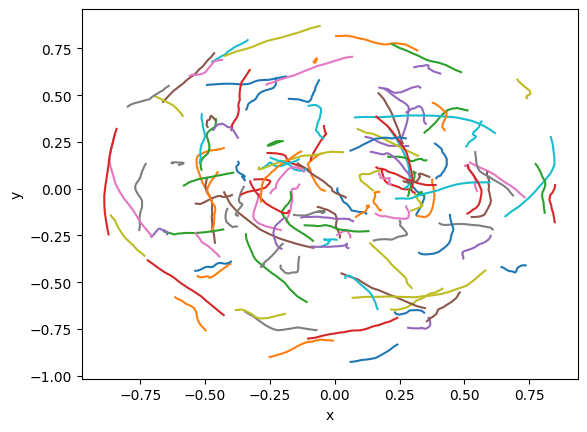

In [70]:
#x and y positions of the end effector

plt.xlabel("x")
plt.ylabel("y")
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])

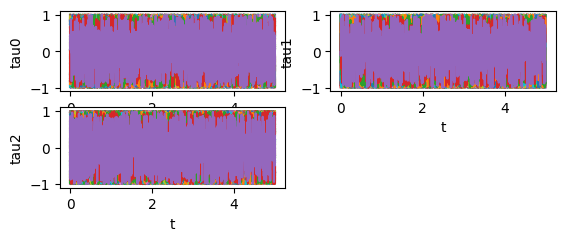

In [71]:
for i in range(num_inputs):
    plt.subplot(4,2,i+1)
    plt.xlabel("t")
    plt.ylabel("tau"+str(i))
    for j in range(num_traj):
        plt.plot(T[:-1],U_full[j,:,i])

***Training and validation datasets***

In [72]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [73]:
# import scipy.io
# Data_set = {"x_end": X_end, "X_full": X_full}
# scipy.io.savemat("Data_set.mat",Data_set)

In [74]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

***Model Training***

In [75]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 40
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 15
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 4e-4 # 5e-4
net_params['epochs'] = 100
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [76]:
train = True

if train == True:
    file = 'saved_models/3R/linear/2D/koop_arch.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'saved_models/3R/linear/2D/koop_arch.pth'
    model_koop_dnn = torch.load(file)


Epoch   1: train loss: 0.8347529173, validation loss: 0.6664745847
Epoch   2: train loss: 0.4384530783, validation loss: 0.3147492055
Epoch   3: train loss: 0.1776831597, validation loss: 0.1250971414
Epoch   4: train loss: 0.0635560676, validation loss: 0.0447651702
Epoch   5: train loss: 0.0195582192, validation loss: 0.0148110333
Epoch   6: train loss: 0.0054011187, validation loss: 0.0055201700
Epoch   7: train loss: 0.0017384674, validation loss: 0.0025382876
Epoch   8: train loss: 0.0008673968, validation loss: 0.0016839928
Epoch   9: train loss: 0.0005784843, validation loss: 0.0011511484
Epoch  10: train loss: 0.0004224223, validation loss: 0.0008102960
Epoch  11: train loss: 0.0003252881, validation loss: 0.0006096873
Epoch  12: train loss: 0.0002637319, validation loss: 0.0005173733
Epoch  13: train loss: 0.0002210267, validation loss: 0.0003463260
Epoch  14: train loss: 0.0001918749, validation loss: 0.0003014321
Epoch  15: train loss: 0.0001745101, validation loss: 0.000316

***Learning Curves***

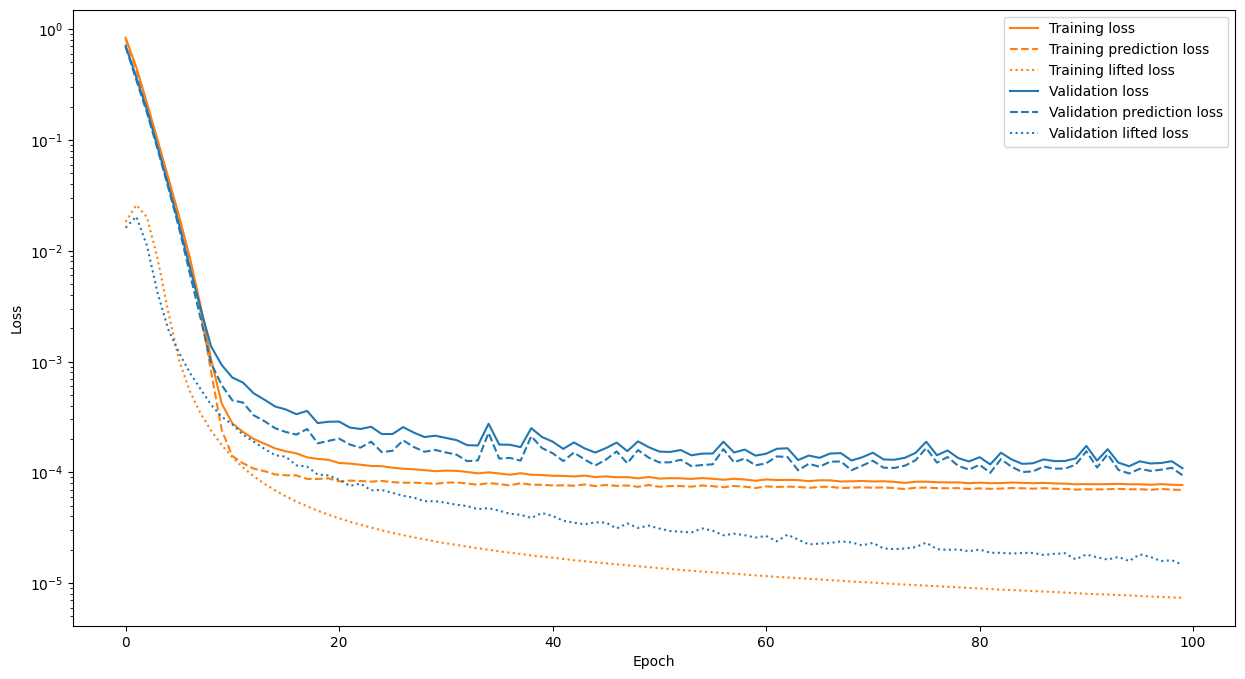

In [15]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot for arch1")
plt.show()


In [16]:
map_net_params = {}
map_net_params["input_dim"] = 3 #number of joint angles
map_net_params["output_dim"] = 2 #x and y position of the end effector
map_net_params["hidden_width"] = 20
map_net_params["hidden_depth"] = 2
map_net_params["batch_size"] = 200
map_net_params["epochs"] = 100
map_net_params["activation_type"] = 'tanh'
map_net_params["lr"] = 1e-3
map_net_params["optimizer"] = 'adam'
map_net_params['l2_reg'] = 0.0
map_net_params['l1_reg'] = 0.0

In [17]:
#dataset
# split training and vaidation datasets
xs_map_train, ys_map_train = X_full[:num_train,:,0:3],X_end[:num_train,:,:]
xs_map_val, ys_map_val = X_full[num_train:,:,0:3],X_end[num_train:,:,:]


In [18]:
ys_map_train.shape, ys_map_val.shape,xs_map_train.shape, xs_map_val.shape

((100, 1001, 2), (25, 1001, 2), (100, 1001, 3), (25, 1001, 3))

Epoch   1: train loss: 0.0864357109, validation loss: 0.0514916581
Epoch   2: train loss: 0.0190021919, validation loss: 0.0332354588
Epoch   3: train loss: 0.0081792465, validation loss: 0.0248002701
Epoch   4: train loss: 0.0048295629, validation loss: 0.0204929660
Epoch   5: train loss: 0.0033315113, validation loss: 0.0172380801
Epoch   6: train loss: 0.0024480461, validation loss: 0.0160862439
Epoch   7: train loss: 0.0018096495, validation loss: 0.0156918585
Epoch   8: train loss: 0.0013197056, validation loss: 0.0152107885
Epoch   9: train loss: 0.0009948698, validation loss: 0.0150113882
Epoch  10: train loss: 0.0007766956, validation loss: 0.0143895152
Epoch  11: train loss: 0.0006202518, validation loss: 0.0138454657
Epoch  12: train loss: 0.0005119119, validation loss: 0.0135994921
Epoch  13: train loss: 0.0004383843, validation loss: 0.0129615550
Epoch  14: train loss: 0.0003836294, validation loss: 0.0126969788
Epoch  15: train loss: 0.0003393169, validation loss: 0.011878

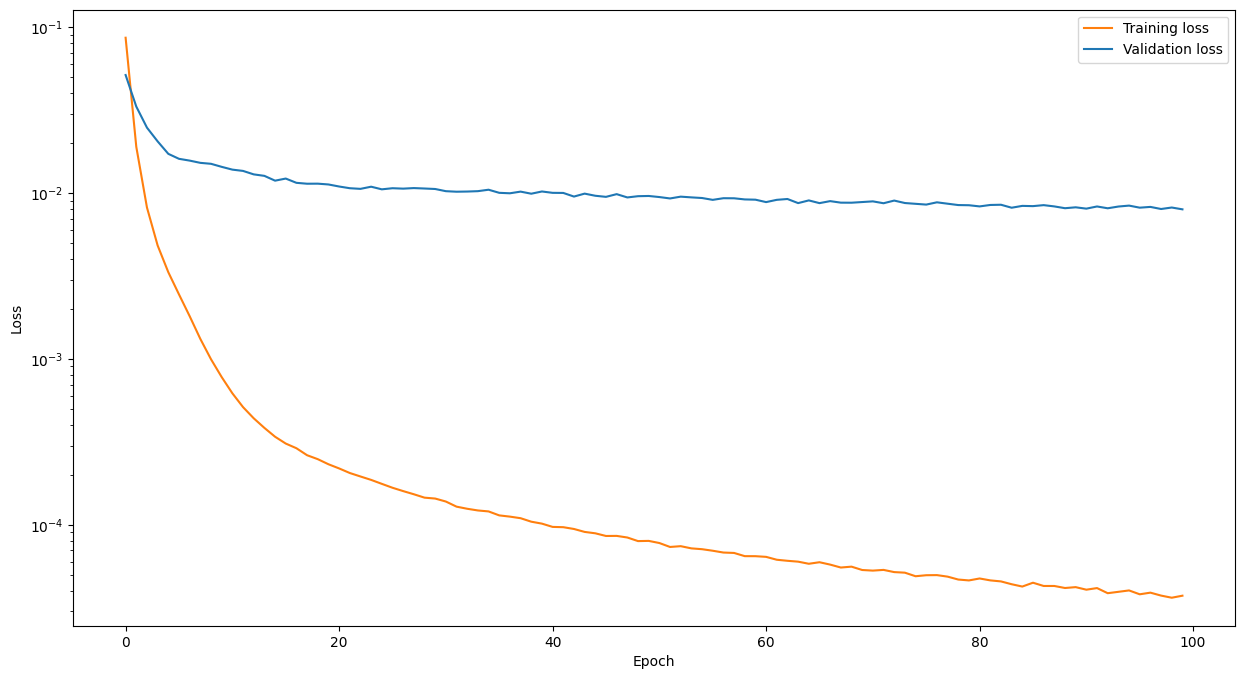

In [19]:
#Initalize network
train = True

if train==True:
    file = "saved_models/3R/bilinear/map_net.pth"
    map_net = map_Net(map_net_params)
    map_net.set_dataset_map(xs_map_train,ys_map_train,xs_map_val,ys_map_val)
    map_net.data_pipeline()
    map_net.plot_loss()
    torch.save(map_net.state_dict(),file)
else:
    file = "saved_models/3R/bilinear/map_net.pth"
    map_net = map_Net(map_net_params)
    map_net.load_state_dict(torch.load(file))


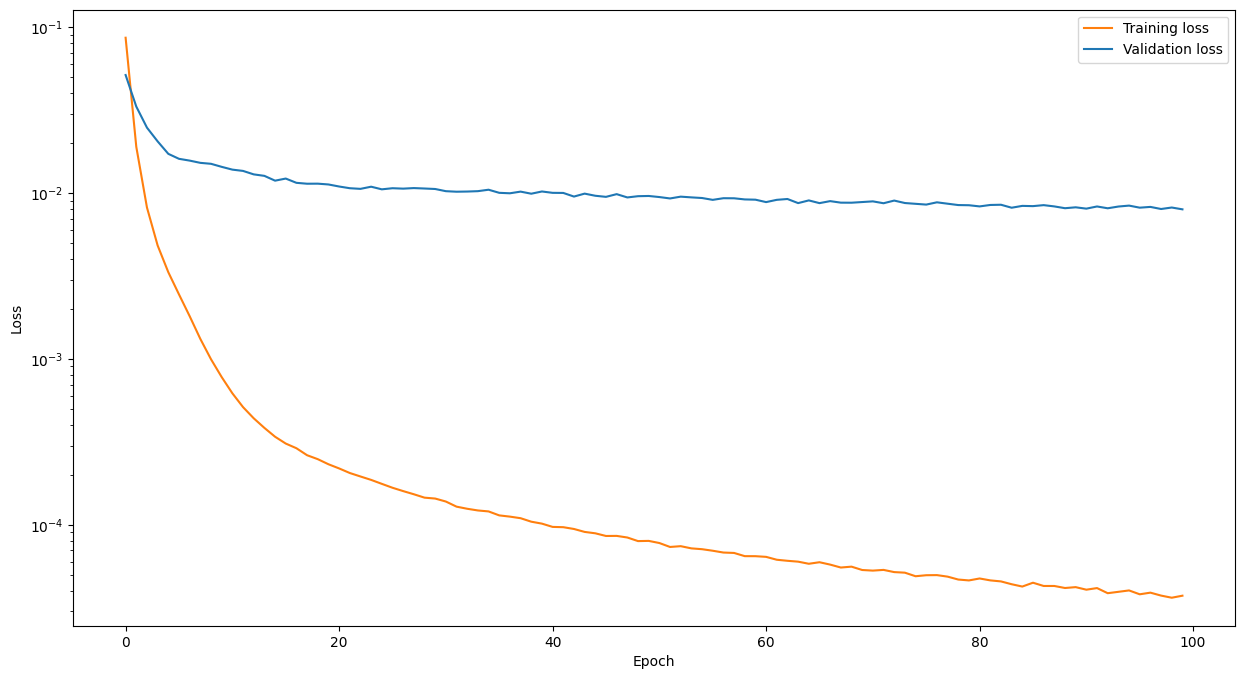

In [20]:
epochs = np.arange(0, map_net_params['epochs'])
plt.figure(figsize=(15,8))
plt.plot(epochs, map_net.train_loss_hist, color='tab:orange', label='Training loss')
plt.plot(epochs, map_net.val_loss_hist, color='tab:blue', label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot of map net for arch1[3,20,20,2]")
plt.show()

In [21]:
import scipy.io

# #save net parameters
# scipy.io.savemat("map_in_weights.mat", {"map_in_weights": map_net.map_net_in.weight.detach().numpy()})
# scipy.io.savemat("map_in_bias.mat", {"map_in_bias": map_net.map_net_in.bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_1.mat",
#                  {"map_hidden_weights_1": map_net.map_net_hid[0].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_1.mat",
#                  {"map_hidden_bias_1": map_net.map_net_hid[0].bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_2.mat",
#                  {"map_hidden_weights_2": map_net.map_net_hid[1].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_2.mat",
#                  {"map_hidden_bias_2": map_net.map_net_hid[1].bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_3.mat",
#                  {"map_hidden_weights_3": map_net.map_net_hid[2].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_3.mat",
#                  {"map_hidden_bias_3": map_net.map_net_hid[2].bias.detach().numpy()})

# scipy.io.savemat("map_out_weights.mat", {"map_out_weights": map_net.map_net_out.weight.detach().numpy()})
# scipy.io.savemat("map_out_bias.mat", {"map_out_bias": map_net.map_net_out.bias.detach().numpy()})

## Test Data Parameters

In [22]:
# test data parameters
num_snaps_val = 2000 # no. of snapshots
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
num_traj_val = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

***Koopman Bilinear Model***


In [36]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(22, 22) (22, 3) (6, 22)


In [77]:
# continious matricies
# continious matricies
Ac = (A-np.eye(n_obs))/dt
Bc = B/dt
Cc = C
Crc = Cc[0:3,:]


In [78]:
print('mean full',np.linalg.pinv(np.matmul(C,Bc)).mean(),np.linalg.pinv(np.matmul(C,Ac)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,Bc)))

print('mean reduced',np.linalg.pinv(np.matmul(Crc,Bc)).mean(),np.linalg.pinv(np.matmul(Crc,Ac)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Crc,Bc)))

mean full 0.7857928 -0.05120403904257211
rank full 3
mean reduced 607.03705 -0.10224725133380108
rank reduced 3


In [24]:
# #SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io

# dyn_matrices = {"A": A, "B": B, "C": C}
# scipy.io.savemat("dyn_mat.mat", dyn_matrices)
# #save encoder parameters
# scipy.io.savemat("in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
# scipy.io.savemat("in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})

# scipy.io.savemat("hidden_weights_1.mat",
#                  {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_1.mat",
#                  {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})

# scipy.io.savemat("hidden_weights_2.mat",
#                  {"encode_hidden_weights_2": model_koop_dnn.net.encoder_fc_hid[1].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_2.mat",
#                  {"encode_hidden_bias_2": model_koop_dnn.net.encoder_fc_hid[1].bias.detach().numpy()})

# scipy.io.savemat("out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
# scipy.io.savemat("out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

In [25]:
encode_out_bias = model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()
encode_out_weights = model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()

***Test Data Generation***

In [26]:
# data_gen
xs_end_test,xs_test, us_test = dynamics_3R_data_gen(dt,num_traj_val, num_snaps_val,num_states,num_inputs, robot_pars)

In [27]:
print(model_koop_dnn.test_loss(xs_test,u_test = us_test))

tensor(6.0022e-05)


In [28]:
xs_end_test.shape

(1, 2001, 2)

In [29]:
basis = model_koop_dnn.net.encode_forward_

In [30]:
X,_ = model_koop_dnn.net.process(xs_test,data_u = us_test)
print(X.shape)

(2000, 15)


In [31]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(2000, 6) (2000, 3) (2000, 6)


***Initial Condition Lifting***

In [32]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_val+1)).T
x_est = np.zeros((num_states,num_snaps_val+1)).T

In [33]:
z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
x_est[0,:] = x[0,:]

***Time Evolution***

In [34]:
for i in range(num_snaps_val):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(np.kron(u[i,:],z[i,:]),B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)     

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 66)

In [ ]:
# theta to end effector positions
# Function for dynamics
def cartesian_pos_gen_3R(th_data, robot_pars):
    #define parameters
    # link lengths
    a1 = robot_pars['a1']
    a2 = robot_pars['a2']
    a3 = robot_pars['a3']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    m3 = robot_pars['m3']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I2']
    I3 = robot_pars['I3']
    #position of CM
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    l3 = robot_pars['l3']

    
    # X  = rows are joint and effector positions and velocities
    num_states = 2*th_data.shape[1]
    num_snaps = th_data.shape[0]
    X = np.empty((num_snaps,num_states)) # cartesian state matrix

    for i in range(num_snaps):
        # time evolution
        X[i,0] = a1*np.cos(th_data[i,0]) + a2*np.cos(th_data[i,0]+th_data[i,1])+a3*np.cos(th_data[i,0]+th_data[i,1]+th_data[i,2]) # end_eff_x
        X[i,1] = a1*np.sin(th_data[i,0]) + a2*np.sin(th_data[i,0]+th_data[i,1])+a3*np.sin(th_data[i,0]+th_data[i,1]+th_data[i,2]) # end_eff_y
        X[i,2] = a1*np.cos(th_data[i,0]) + a2*np.cos(th_data[i,0]+th_data[i,1]) # jt2_x
        X[i,3] = l1*np.sin(th_data[i,0]) + l2*np.sin(th_data[i,0]+th_data[i,1]) # jt2_y
        X[i,4] = l1*np.cos(th_data[i,0]) #jt1_x
        X[i,5] = l1*np.sin(th_data[i,0]) #jt1_y

        #joint velocities
        X[i,6] = -a1*np.sin(th_data[i,0])*th_data[i,3] - a2*np.sin(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4])-a3*np.sin(th_data[i,0]+th_data[i,1]+th_data[i,2])*(th_data[i,3]+th_data[i,4]+th_data[i,5]) # end_eff_x
        X[i,7] = a1*np.cos(th_data[i,0])*th_data[i,3] + a2*np.cos(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4])+a3*np.cos(th_data[i,0]+th_data[i,1]+th_data[i,2])*(th_data[i,3]+th_data[i,4]+th_data[i,5]) # end_eff_y
        X[i,8] = -a1*np.sin(th_data[i,0])*th_data[i,3] - a2*np.sin(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4]) # end_eff_x
        X[i,9] = a1*np.cos(th_data[i,0])*th_data[i,3] + a2*np.cos(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4]) # end_eff_y
        X[i,10] = -a1*np.sin(th_data[i,0])*th_data[i,3] #jt_x
        X[i,11] = a1*np.cos(th_data[i,0])*th_data[i,3] #jt_y
    return X

# Cartesian Positions

In [ ]:
x_cart = cartesian_pos_gen_3R(x, robot_pars)
x_cart_est = cartesian_pos_gen_3R(x_est, robot_pars)

***Visualization***

# Joint Space

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,0],label ='Actual')
plt.plot(T,x_est[:,0],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,1],label ='Actual')
plt.plot(T,x_est[:,1],label = 'estimated(bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

In [ ]:

plt.figure()
plt.plot(T[:-1],x[:,2],label ='Actual')
plt.plot(T,x_est[:,2],label = 'estimated(bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,3],label ='Actual')
plt.plot(T,x_est[:,3],label = 'estimated(bilinear)')
plt.title('Theta_1_dot')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,4],label ='Actual')
plt.plot(T,x_est[:,4],label = 'estimated(bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('theta_2_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,5],label ='Actual')
plt.plot(T,x_est[:,5],label = 'estimated(bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()

# Cartesian Space

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,0],label ='Actual')
plt.plot(T[:],x_cart_est[:,0],label = 'estimated(bilinear)')
plt.title('end effector x position comparison')
plt.xlabel('t')
plt.ylabel('x_1')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,1],label ='Actual')
plt.plot(T[:],x_cart_est[:,1],label = 'estimated(bilinear)')
plt.title('end effector y position comparison')
plt.xlabel('t')
plt.ylabel('y_1')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_cart[:,0],x_cart[:,1],label ='Actual')
plt.plot(x_cart_est[:,0],x_cart_est[:,1],label = 'estimated(bilinear)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_cart[:,2],x_cart[:,3],label ='Actual')
plt.plot(x_cart_est[:,2],x_cart_est[:,3],label = 'estimated(bilinear)')
plt.xlabel('j2_x')
plt.ylabel('j2_y')
plt.title('end effector of joint 2 position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_cart[:,4],x_cart[:,5],label ='Actual')
plt.plot(x_cart_est[:,4],x_cart_est[:,5],label = 'estimated(bilinear)')
plt.xlabel('j3_x')
plt.ylabel('j3_y')
plt.title('end effector position comparison of joint 3')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,6],label ='Actual')
plt.plot(T[:],x_cart_est[:,6],label = 'estimated(bilinear)')
plt.title('end effector x velocity position comparison')
plt.xlabel('t')
plt.ylabel('x_1_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,7],label ='Actual')
plt.plot(T[:],x_cart_est[:,7],label = 'estimated(bilinear)')
plt.title('end effector y velocity position comparison')
plt.xlabel('t')
plt.ylabel('y_1_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,8],label ='Actual')
plt.plot(T[:],x_cart_est[:,8],label = 'estimated(bilinear)')
plt.title('Joint 2 x velocity position comparison')
plt.xlabel('t')
plt.ylabel('x dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,9],label ='Actual')
plt.plot(T[:],x_cart_est[:,9],label = 'estimated(bilinear)')
plt.title('Joint 2 y velocity comparison')
plt.xlabel('t')
plt.ylabel('y dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,10],label ='Actual')
plt.plot(T[:],x_cart_est[:,10],label = 'estimated(bilinear)')
plt.title('Joint 1 x velocity comparison')
plt.xlabel('t')
plt.ylabel('x dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,7],label ='Actual')
plt.plot(T[:],x_cart_est[:,7],label = 'estimated(bilinear)')
plt.title('Joint 1 y velocity position comparison')
plt.xlabel('t')
plt.ylabel('y dot')
plt.legend()

In [ ]:
# plt.figure()
# plt.plot(T[:-1],error_mse_joint_tot)
# plt.xlabel('t')
# plt.ylabel('error_mse_joint_tot')
# plt.title('Total Joint space error evolution')
# plt.savefig("output.jpg",format ='jpg', dpi = 100)

In [ ]:
# plt.figure()
# plt.plot(T[:-1],error_mse_joint_pos)
# plt.xlabel('t')
# plt.ylabel('error_mse_joint_pos')
# plt.title('Joint position error evolution')
# plt.savefig("output.jpg",format ='jpg', dpi = 100)

In [ ]:
# plt.figure()
# plt.plot(T[:-1],error_mse_joint_vel)
# plt.xlabel('t')
# plt.ylabel('error_mse_joint_vel')
# plt.title('Joint vel error evolution')
# plt.savefig("output.jpg",format ='jpg', dpi = 100)

In [ ]:
# plt.figure()
# plt.plot(T[:-1],error_mse_cart_tot)
# plt.xlabel('t')
# plt.ylabel('error_mse_cart_tot')
# plt.title('Total cartesian space error evolution')

In [ ]:
# plt.figure()
# plt.plot(T[:-1],error_mse_cart_pos_ef)
# plt.xlabel('t')
# plt.ylabel('error_mse_cart_pos_ef')
# plt.title('End Effector position error evolution')

In [ ]:
# plt.figure()
# plt.plot(T[:-1],error_mse_cart_vel_ef)
# plt.xlabel('t')
# plt.ylabel('error_mse_cart_vel_ef')
# plt.title('End Effector vel error evolution')

In [ ]:
# data_gen
xs_end_test,xs_test, us_test = dynamics_3R_data_gen(dt,num_traj_val, num_snaps_val,num_states,num_inputs,robot_pars)

In [ ]:
#testing the map network
theta_test = xs_test[:,:,0:3]
theta_test = theta_test.T.reshape((3,2001),order='F')
theta_test = theta_test.T
x_end_pred = np.empty((num_snaps_val+1,2))

In [ ]:
for i in range(num_snaps_val):
    th_t = torch.from_numpy(theta_test[i,:]).float()
    x_end_pred[i,:] = map_net(th_t).detach().numpy()

In [ ]:

#plot
plt.figure()
plt.plot(T[:-1],xs_end_test[:,0:-1,0].T,label='x end actual')
plt.plot(T[:-1],x_end_pred[0:-1,0],label='x end predicted')
plt.xlabel('t')
plt.ylabel('x end')
plt.legend()
plt.title('actual and predicted position of end effector')
plt.show()

In [ ]:
plt.figure()
plt.plot(T[:-1],xs_end_test[:,0:-1,1].T,label='y end actual')
plt.plot(T[:-1],x_end_pred[0:-1,1],label='y end predicted')
plt.xlabel('t')
plt.ylabel('x end')
plt.legend()
plt.title('actual and predicted position of end effector')
plt.show()

In [ ]:
#error plot
plt.figure()
error_x = xs_end_test[:,0:-1,0]-x_end_pred[0:-1,0]
error_y = xs_end_test[:,0:-1,1]-x_end_pred[0:-1,1]
plt.plot(T[:-1],error_x.T,label='error in x position')
plt.plot(T[:-1],error_y.T,label='error in y position')
plt.xlabel('t')
plt.ylabel('error')
plt.legend()
plt.title('x and y error')
plt.show()

# Control of the bilinear model

In [ ]:
print('mean full',np.linalg.pinv(np.matmul(C,Bc)).mean(),np.linalg.pinv(np.matmul(C,Ac)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,Bc)))

print('mean reduced',np.linalg.pinv(np.matmul(Crc,Bc)).mean(),np.linalg.pinv(np.matmul(Crc,Ac)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Crc,Bc)))

In [ ]:
# control process pars
# test data parameters
t_con = 10
num_snaps_con = int(t_con/dt) # no. of snapshots
T = np.linspace(0,num_snaps_con*dt, num_snaps_con+1)

In [ ]:
# comparison of continious and discreate matricies
# initilizations
z_disc = np.empty((n_obs,num_snaps_con+1)).T
z_cont = np.empty((n_obs,num_snaps_con+1)).T
u = np.zeros((num_inputs,num_snaps_con)).T
# initial values
x = np.random.rand(1,num_states)

In [ ]:
z_disc[0,:] = lift(x[0,:],model_koop_dnn, net_params)
z_cont[0,:] = z_disc[0,:]
u[0,:] = (2*np.random.rand(1,num_inputs)-1)

In [ ]:
for i in range(num_snaps_con):
  #bilinear
    u[i,:] = (2*np.random.rand(1,num_inputs)-1)
    z_disc[i+1,:] = np.matmul(z_disc[i,:],A.T)+np.matmul(np.kron(u[i,:],z_disc[i,:]),B.T)
    #z[i+1,:] = z[i,:] + z_dot[i,:]
    z_dot = np.matmul(z_cont[i,:],Ac.T)+np.matmul(np.kron(u[i,:],z_cont[i,:]),Bc.T)
    z_cont[i+1,:] = z_cont[i,:] + z_dot*dt

In [ ]:
error_disc = np.sqrt(np.square(z_cont-z_disc).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:],error_disc)
plt.xlabel('t')
plt.ylabel('error_disc')
plt.title('discreatization error evolution')

## Dynamics

In [ ]:
# theta to end effector positions
# Function for dynamics
def forward_kinematics_2r(th_data,th_dot_data, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']
    # theta_data = (num_snaps, num_states)
    
    # X  = rows are joint and effector positions and velocities
    num_states = 4*th_data.shape[1]
    num_snaps = th_data.shape[0]
    X = np.empty((num_snaps,num_states)) # cartesian state matrix

    for i in range(num_snaps):
        # time evolution
        X[i,0] = l1*np.cos(th_data[i,0]) + l2*np.cos(th_data[i,0]+th_data[i,1]) # end_eff_x
        X[i,1] = l1*np.sin(th_data[i,0]) + l2*np.sin(th_data[i,0]+th_data[i,1]) # end_eff_y
        X[i,2] = l1*np.cos(th_data[i,0]) #jt_x
        X[i,3] = l1*np.sin(th_data[i,0]) #jt_y
        X[i,4] = -l1*np.sin(th_data[i,0])*th_dot_data[i,0] - l2*np.sin(th_data[i,0]+th_data[i,1])*(th_dot_data[i,0]+th_dot_data[i,1]) # end_eff_x
        X[i,5] = l1*np.cos(th_data[i,0])*th_dot_data[i,0] + l2*np.cos(th_data[i,0]+th_data[i,1])*(th_dot_data[i,0]+th_dot_data[i,1]) # end_eff_y
        X[i,6] = -l1*np.sin(th_data[i,0])*th_dot_data[i,0] #jt_x
        X[i,7] = l1*np.cos(th_data[i,0])*th_dot_data[i,0] #jt_y
    return X

In [ ]:
# theta to end effector positions
# Function for dynamics
def forward_map_2r(th_data, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']
    # theta_data = (num_snaps, num_states)
    
    # X  = rows are joint and effector positions and velocities
    num_states = 4
    num_snaps = 1
    X = np.empty((num_states,)) # cartesian state matrix

    # time evolution
    X[0] = l1*np.cos(th_data[0]) + l2*np.cos(th_data[0]+th_data[1]) # end_eff_x
    X[1] = l1*np.sin(th_data[0]) + l2*np.sin(th_data[0]+th_data[1]) # end_eff_y
    X[2] = l1*np.cos(th_data[0]) #jt_x
    X[3] = l1*np.sin(th_data[0]) #jt_y  
    
    return X

In [ ]:
def Jacobian_2r(th_data, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']
    # theta_data = (num_snaps, num_states)
    
    # X  = rows are joint and effector positions and velocities
    J = np.empty((2,2)) # cartesian state matrix

    # time evolution
    J[0,0] = -l1*np.sin(th_data[0]) - l2*np.sin(th_data[0]+th_data[1]) # end_eff_x
    J[0,1] = -l2*np.sin(th_data[0]+th_data[1])
    J[1,0] = l1*np.cos(th_data[0]) + l2*np.cos(th_data[0]+th_data[1])
    J[1,1] = l2*np.cos(th_data[0]+th_data[1])
    
    return J

In [ ]:
#function for dynamics in tau to theta conversion
def dynamics_2R(dt, u, th, th_dot, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']

    # gravity
    g = 9.81*0
    # matrix initializations
    tau = u.reshape(-1,1)
    # mass matrix
    m11 = (I1+I2+m1*l1**2) + (m2*l2**2/4+m1*l1**2)/4 + (2*m2*l1*l2*np.cos(th[1]));
    m12 = I2+(m2*l2**2)/4 + m2*l1*l2*np.cos(th[1])/2;
    m21=m12;
    m22 = I2 + (m2*l2**2)/4;

    M = np.array([[m11,m12],[m21,m22]])

    # coriolis tersms
    c1 = -m2*l1*l2*0.5*np.sin(th[1])*(2*th_dot[0]*th_dot[1]+th_dot[1]**2);
    c2 = m2*l1*l2*np.sin(th[1])*th_dot[1]**2;

    C = np.array([[c1],[c2]]) 

    # gravity terms     
    g1 = m2*g*(l1*np.cos(th[0])+l2*np.cos(th[0]+th[1]))+m1*g*l1*0.5*np.cos(th[0]);
    g2 = m2*g*l2*0.5*np.cos(th[0]+th[1]);

    G = np.array([[g1],[g2]]) 

    # inputs
    
    # theta evolution
    th_ddot = np.matmul(np.linalg.inv(M),(tau-G-C)).reshape(2,)
    th_dot_next = th_dot + th_ddot*dt
    th_next = th + th_dot*dt + (1/2)*th_ddot*dt**2

    return th_next, th_dot_next

## Noise Generation

In [ ]:
def gen_noise(t,amp,state,noise_nature):
    num_states = int(state.shape[0])
    noise = np.empty((1,num_states))
    if noise_nature == 'constant':
        noise[0,:] = np.ones((1,num_states))*ep
    elif noise_nature == 'sinosoidal':
        for j in range(num_states):
            if j%2 == 0:
                noise[0,j] = ep*np.sin(4*np.pi*t)
            else:
                noise[0,j] = ep*np.cos(4*np.pi*t)
    elif noise_nature == 'state_dependent':
        noise[0,0] = ep*np.sin(4*np.pi*t*state[0])
        noise[0,1] = ep*np.cos(4*np.pi*t*state[0])
        noise[0,2] = ep*np.sin(4*np.pi*t)
        noise[0,3] = ep*np.cos(4*np.pi*t)
    else:
        noise[0,:] = np.zeros((1,num_states))
    return noise
        
        

## Control Parameters

In [ ]:
# initialize parameters
# control process pars
t_run = 10
n_p = 1 #no of periods
t_sim = n_p*t_run 
num_snaps_sim = int(t_sim/dt) # no. of snapshots
T = np.linspace(0,num_snaps_sim*dt, num_snaps_sim+1)
num_cont_outs = 2 # no of controllable outputs
gamma_traced = 10
gamma_res = 40

l = 1
c = 0.02;

# noise parameters
noise = False
noise_nature = 'constant'
if noise:
    ep = 0.01 # amplitude of noise
else:
    ep = 0

In [ ]:
#initialize matricies
# comparison of continious and discreate matricies
# initilizations
z = np.empty((n_obs,num_snaps_sim+1)).T # from the measurement
z_dot_est = np.empty((n_obs,num_snaps_sim)).T # from the measurement
z_dot_actual = np.empty((n_obs,num_snaps_sim)).T # from the measurement
z_m = np.empty((n_obs,num_snaps_sim+1)).T # from the model
u = np.zeros((num_inputs,num_snaps_sim)).T
#
# initial values
th = np.zeros((num_states,num_snaps_sim+1)).T #[th th_dot]
th_actual = np.empty((num_states,num_snaps_sim+1)).T
# considering only the end effecctor
x_desired = np.empty((num_cont_outs,num_snaps_sim+1)).T
x_desired_dot = np.empty((num_cont_outs,num_snaps_sim+1)).T
x_traced = np.empty((num_cont_outs,num_snaps_sim+1)).T
x_actual = np.empty((num_cont_outs,num_snaps_sim+1)).T
error_traced = np.zeros((num_cont_outs,num_snaps_sim)).T
#considering the full state matrix
x_actual = np.empty((4,num_snaps_sim+1)).T
noise = np.empty((num_states,num_snaps_sim+1)).T #full states
# residual initialization
rd = np.empty((n_obs,num_snaps_sim+1)).T
rd_dot = np.empty((n_obs,num_snaps_sim)).T

In [ ]:
# set initial values
th[0,:2] = np.array([0.1, np.pi*0.9])
th[0,2:4] = np.zeros((2,))
# end effector quantities
x_actual[0,:] = forward_map_2r(th[0,:2],robot_pars)
print(x_actual[0,:])

#noise addition
noise[0,:] = gen_noise(0,ep,x_actual[0,:],noise_nature)
x_actual[0,:] += noise[0,:]
print(x_actual[0,:])
x_traced[0,:] = x_actual[0,:2]
x_desired[0,:] = x_traced[0,:]


# inputs
u[0,:] = np.zeros((1,num_inputs))
x_desired_dot[0,0] = -2*c*2*np.pi*np.sin(2*np.pi*0/t_run)/t_run+c*4*np.pi*np.sin(4*np.pi*0/t_run)/t_run;
x_desired_dot[0,1] =  2*c*2*np.pi*np.cos(2*np.pi*0/t_run)/t_run-c*4*np.pi*np.cos(4*np.pi*0/t_run)/t_run

#lifted quantities
z[0,:] = lift(th[0,:],model_koop_dnn, first_obs_const, override_C) # estimated lifed state        
z_m[0,:] = z[0,:]
# residual
rd[0,:] = np.zeros((n_obs,1)).T

In [ ]:
for i in range(num_snaps_sim):
  #bilinear
    t = T[i+1]
    # desired positions
    x_desired[i+1,0] = 2*c*np.cos(2*np.pi*t/t_run)-c*np.cos(4*np.pi*t/t_run) + x_desired[0,0] - c
    x_desired[i+1,1] = 2*c*np.sin(2*np.pi*t/t_run)-c*np.sin(4*np.pi*t/t_run) + x_desired[0,1]
    # desirded velocities
    x_desired_dot[i+1,0] = -2*c*2*np.pi*np.sin(2*np.pi*t/t_run)/t_run+c*4*np.pi*np.sin(4*np.pi*t/t_run)/t_run;
    x_desired_dot[i+1,1] =  2*c*2*np.pi*np.cos(2*np.pi*t/t_run)/t_run-c*4*np.pi*np.cos(4*np.pi*t/t_run)/t_run
    
    # tracking error
    error_traced[i,:] = x_actual[i,0:2] - x_desired[i,:]
    u[i,:] = np.matmul(np.linalg.pinv(np.matmul(Jacobian_2r(th[i,:2], robot_pars),
                np.matmul(Crc,np.matmul(Bc,np.kron(np.identity(2),z[i,:]).T)))),
                (x_desired_dot[i,:].T - np.matmul(Jacobian_2r(th[i,:2],robot_pars),
                np.matmul(Crc,np.matmul(Ac,z[i,:].T))) - np.matmul(Jacobian_2r(th[i,:2],robot_pars),
                np.matmul(Crc,rd[i,:].T)) 
                 - gamma_traced*error_traced[i,:].T))                                    
    
    
    #u[i,:] = gamma_traced*error_traced[i,:].T # proportional control
    # lifted state velocities
    z_dot_est[i,:] = np.matmul(z[i,:],Ac.T) + np.matmul(np.kron(u[i,:],z[i,:]),Bc.T) + rd[i,:]
    if i == 0:
        z_dot_actual[i,:] = np.zeros((1,n_obs))
    else:
        z_dot_actual[i,:] = (z[i,:]-z[i-1,:])/dt
    
    rd_dot[i,:] = gamma_res*(z_dot_actual[i,:] - z_dot_est[i-1,:])
    rd[i+1,:] = rd[i,:] + rd_dot[i,:]*dt
    

    
   # next state raise
    th[i+1,:2],th[i+1,2:] = dynamics_2R(dt, u[i,:], th[i,:2], th[i,2:], robot_pars)
    z[i+1,:] = lift(th[i+1,:],model_koop_dnn, first_obs_const, override_C)
    x_actual[i+1,:] = forward_map_2r(th[i+1,:2],robot_pars)
    noise[i+1,:] = gen_noise(t,ep,x_actual[i+1,:],noise_nature)
    x_actual[i+1,:] += noise[i+1,:]
    
    # model states
    z_m[i+1,:] = z[i,:] + z_dot_est[i,:]*dt            
    th_traced_full = np.matmul(z_m[i+1,:],Crc.T)
    x_traced_full = forward_map_2r(th_traced_full[:2],robot_pars)
    x_traced[i+1,:] = x_traced_full[:2]

In [ ]:
print(A)

In [ ]:
plt.figure()
plt.plot(x_desired[:,0],x_desired[:,1],label ='desired')
plt.plot(x_traced[:,0],x_traced[:,1],'r--',label = 'esimated(bilinear)', )
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_desired[:,0],x_desired[:,1],label ='desired')
plt.plot(x_actual[:,0],x_actual[:,1],'r--',label = 'Actual Model' )
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_actual[:,0],x_actual[:,1],label ='Actual')
plt.plot(x_traced[:,0],x_traced[:,1],'r--',label = 'esimated(bilinear)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
u_norm = np.sqrt(np.square(u).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:-1],u_norm)
plt.xlabel('t')
plt.ylabel('||u||')
plt.title('control norm evolution')

In [ ]:
plt.figure()
plt.plot(T,x_actual[:,0],label = 'x')
plt.plot(T,x_actual[:,1],label = 'y')

In [ ]:
error_model = np.sqrt(np.square(x_traced-x_actual[:,:2]).mean(axis=1))
error_tracking = np.sqrt(np.square(x_actual[:,:2]-x_desired).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:],error_model)
plt.xlabel('t')
plt.ylabel('error_model')
plt.title('model error evolution')

In [ ]:
plt.figure()
plt.plot(T[:],error_tracking)
plt.xlabel('t')
plt.ylabel('error_track')
plt.title('tracking error evolution')

In [ ]:
z_norm = np.sqrt(np.square(z).mean(axis=1))
x_norm = np.sqrt(np.square(x_actual).mean(axis=1))
noise_norm = np.sqrt(np.square(noise).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:],x_norm)
plt.xlabel('t')
plt.ylabel('||x||')
plt.title('x norm evolution')

In [ ]:
plt.figure()
plt.plot(T[:],z_norm)
plt.xlabel('t')
plt.ylabel('||z||')
plt.title('z norm evolution')

In [ ]:
plt.figure()
plt.plot(T[:],noise_norm)
plt.xlabel('t')
plt.ylabel('error_model')
plt.title('noise norm evolution')

In [ ]:
lift(np.array([-1,2,-3,7.4]),model_koop_dnn,first_obs_const,override_C)

In [1]:
map_net.map_net_in.weight

NameError: name 'map_net' is not defined